In [ ]:
import pandas as pd
import os
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

c:\Users\VSIE43\AppData\Local\miniconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\VSIE43\AppData\Local\miniconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: Sample size too small for normal approximation.
  res = hypotest_fun_out(*samples, **kwds)


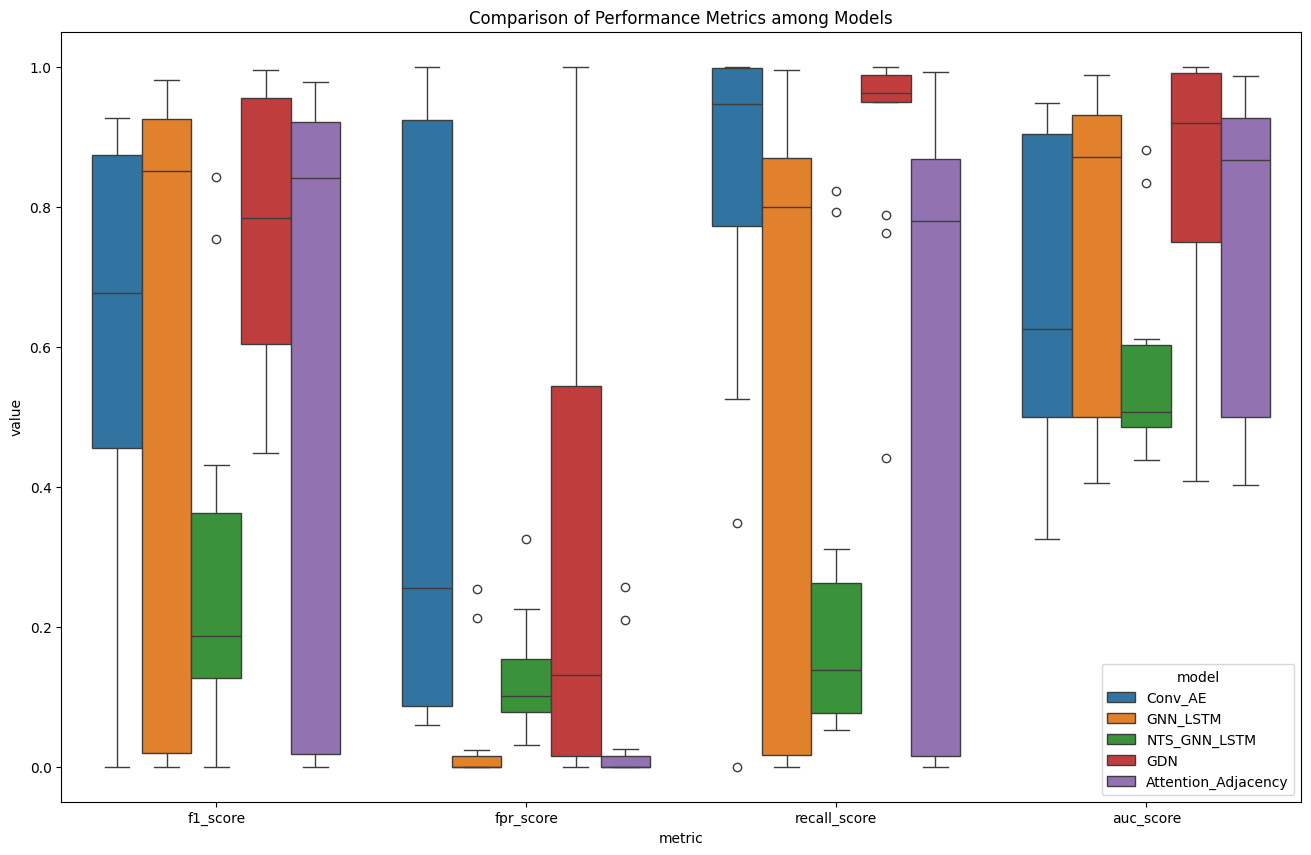


Descriptive Statistics for Conv_AE:
         f1_score  fpr_score  recall_score  auc_score
count  14.000000  14.000000     14.000000  14.000000
mean    0.620272   0.467330      0.799186   0.665928
std     0.280703   0.405376      0.303258   0.228356
min     0.000000   0.058824      0.000000   0.325393
25%     0.454734   0.085844      0.771592   0.500000
50%     0.676197   0.255107      0.946449   0.625084
75%     0.873575   0.924332      0.998171   0.904386
max     0.925881   1.000000      1.000000   0.948547

----------------------------------------


Descriptive Statistics for GNN_LSTM:
         f1_score  fpr_score  recall_score  auc_score
count  14.000000  14.000000     14.000000  14.000000
mean    0.584931   0.036486      0.560012   0.761763
std     0.443584   0.084143      0.429177   0.221281
min     0.000000   0.000000      0.000000   0.405128
25%     0.019101   0.000000      0.016038   0.500000
50%     0.851314   0.000000      0.799817   0.871260
75%     0.925702   0.014747     

In [28]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel, wilcoxon
import seaborn as sns
import matplotlib.pyplot as plt
from openpyxl import load_workbook
from openpyxl.styles import PatternFill

# Function to standardize column names
def standardize_column_names(df_list):
    standardized_columns = {
        'f1_score': 'f1_score',
        'fpr_score': 'fpr_score',
        'recall_score': 'recall_score',
        'auc_score': 'auc_score',
        'fpr': 'fpr_score',  # standardizing 'fpr' to 'fpr_score'
        'precision': 'precision'  # additional column in data_gdn
    }
    for name, df in df_list.items():
        df.rename(columns=standardized_columns, inplace=True)

# Function to compute descriptive statistics
def compute_descriptive_statistics(df_list):
    stats = {}
    for name, df in df_list.items():
        stats[name] = df.describe()
    return stats

# Function to perform paired t-test
def perform_paired_ttest(df1, df2):
    return {metric: ttest_rel(df1[metric], df2[metric]) for metric in df1.columns if pd.api.types.is_numeric_dtype(df1[metric])}

# Function to perform Wilcoxon signed-rank test
def perform_wilcoxon_test(df1, df2):
    return {metric: wilcoxon(df1[metric], df2[metric]) for metric in df1.columns if pd.api.types.is_numeric_dtype(df1[metric])}

# Function to compute effect size (Cohen's d)
def compute_effect_size(df1, df2):
    return {metric: (df1[metric].mean() - df2[metric].mean()) / np.sqrt((df1[metric].std() ** 2 + df2[metric].std() ** 2) / 2) for metric in df1.columns if pd.api.types.is_numeric_dtype(df1[metric])}

# Function to prepare data for visualization
def prepare_data_for_visualization(df_list):
    combined = pd.concat(df_list.values())
    melted = combined.melt(id_vars='model', var_name='metric', value_name='value')
    return melted

# Function to visualize data
def visualize_data(df):
    plt.figure(figsize=(16, 10))
    sns.boxplot(x='metric', y='value', hue='model', data=df)
    plt.title('Comparison of Performance Metrics among Models')
    plt.show()

# Function to print results in table format
def extract_ttest_results(ttest_results):
    return {metric: (result.statistic, result.pvalue, result.df) for metric, result in ttest_results.items()}

def extract_wilcoxon_results(wilcoxon_results):
    return {metric: (result.statistic, result.pvalue) for metric, result in wilcoxon_results.items()}

def get_combined_results(ttest_results, wilcoxon_results, effect_size_results, comparison_name):
    ttest_extracted = extract_ttest_results(ttest_results)
    wilcoxon_extracted = extract_wilcoxon_results(wilcoxon_results)

    df_ttest = pd.DataFrame(ttest_extracted, index=['t_statistic', 't_pvalue', 't_df']).T
    df_wilcoxon = pd.DataFrame(wilcoxon_extracted, index=['wilcoxon_statistic', 'wilcoxon_pvalue']).T
    df_effect_size = pd.DataFrame(effect_size_results, index=['Effect Size']).T

    df_combined = df_ttest.join(df_wilcoxon).join(df_effect_size)
    df_combined['comparison'] = comparison_name

    return df_combined

# Function to write results to Excel
def write_results_to_excel(comparisons, filename='results.xlsx'):
    combined_df = pd.DataFrame()
    for model1, model2, ttest_results, wilcoxon_results, effect_size_results in comparisons:
        comparison_name = f"{model1} vs {model2}"
        df_combined = get_combined_results(ttest_results, wilcoxon_results, effect_size_results, comparison_name)
        combined_df = pd.concat([combined_df, df_combined])

    combined_df.to_excel(filename, sheet_name='Results', index=True)

    # Apply conditional formatting to highlight p-value cells less than 0.05
    wb = load_workbook(filename)
    ws = wb['Results']
    fill = PatternFill(start_color="FFFF00", end_color="FFFF00", fill_type="solid")

    for row in ws.iter_rows(min_row=2, max_col=ws.max_column, max_row=ws.max_row):
        for cell in row:
            if cell.column_letter in ['C', 'F'] and isinstance(cell.value, float) and cell.value < 0.05:
                cell.fill = fill

    wb.save(filename)

# Main function to execute the workflow
def main(df_list):
    standardize_column_names(df_list)
    
    desc_stats = compute_descriptive_statistics(df_list)

    # Perform paired t-tests, Wilcoxon tests, and compute effect sizes for all pairs of models
    model_names = list(df_list.keys())
    comparisons = []
    for i in range(len(model_names)):
        for j in range(i + 1, len(model_names)):
            model1 = model_names[i]
            model2 = model_names[j]
            ttest_results = perform_paired_ttest(df_list[model1], df_list[model2])
            wilcoxon_results = perform_wilcoxon_test(df_list[model1], df_list[model2])
            effect_size_results = compute_effect_size(df_list[model1], df_list[model2])
            comparisons.append((model1, model2, ttest_results, wilcoxon_results, effect_size_results))

    # Combine dataframes for visualization
    df_combined = prepare_data_for_visualization(df_list)
    visualize_data(df_combined)

    # Print results in table format and write to Excel
    write_results_to_excel(comparisons)

    # Print descriptive statistics
    for model, stats in desc_stats.items():
        print(f"\nDescriptive Statistics for {model}:\n", stats)
        print("\n----------------------------------------\n")

# Data
data_conv_ae = {
    'f1_score': [0.433179724, 0.698817106, 0.541496599, 0.519395135, 0.922902494, 0.925880923, 0.905089409, 0, 0.906698565, 0.779032258, 0.291280148, 0.653576438, 0.340686275, 0.765778401],
    'fpr_score': [1, 1, 1, 1, 0.095588235, 0.058823529, 0.075221239, 0.075110457, 0.08259587, 0.25295858, 0.697329377, 0.253709199, 0.694772344, 0.256505576],
    'recall_score': [1, 1, 1, 1, 0.992682927, 0.947761194, 0.948126801, 0, 0.945137157, 0.824232082, 0.348115299, 0.754045307, 0.524528302, 0.90397351],
    'auc_score': [0.5, 0.5, 0.5, 0.5, 0.948547346, 0.944468832, 0.936452781, 0.462444772, 0.931270643, 0.785636751, 0.325392961, 0.750168054, 0.414877979, 0.823733967]
}

data_gnn_lstm = {
    'f1_score': [0.870870871, 0.927374302, 0.955974843, 0.789644013, 0.980769231, 0.906122449, 0.920684292, 0, 0.92942743, 0, 0, 0.831758034, 0.076404494, 0],
    'fpr_score': [0, 0, 0.02351314, 0.212820513, 0.01920439, 0, 0, 0, 0.001375516, 0, 0, 0, 0.253894081, 0],
    'recall_score': [0.771276596, 0.864583333, 0.954773869, 0.926582278, 0.995121951, 0.828358209, 0.853025937, 0, 0.87032419, 0, 0, 0.71197411, 0.064150943, 0],
    'auc_score': [0.885638298, 0.932291667, 0.965630365, 0.856880883, 0.987958781, 0.914179104, 0.926512968, 0.5, 0.934474337, 0.5, 0.5, 0.855987055, 0.405128431, 0.5]
}

data_nts_gnn_lstm = {
    'f1_score': [0.84180791, 0.430604982, 0.17208413, 0.151162791, 0.061810515, 0.0875, 0, 0.252873563, 0.132669983, 0.124242424, 0.20204978, 0.753709199, 0.224719101, 0.399038462],
    'fpr_score': [0.03142329, 0.15, 0.110650069, 0.105128205, 0.07818913, 0.097661623, 0.097661623, 0.078202198, 0.222833563, 0.04551724, 0.225449516, 0.15532697, 0.325545171, 0.052819093],
    'recall_score': [0.792553191, 0.311504167, 0.113065327, 0.098734177, 0.052238806, 0.052238806, 0.052238806, 0.163771712, 0.099750626, 0.069965987, 0.193523316, 0.822006472, 0.226415094, 0.274834437],
    'auc_score': [0.880564951, 0.582552083, 0.501207629, 0.496802986, 0.497182891, 0.480724753, 0.451619188, 0.545484757, 0.438452484, 0.512224314, 0.463771196, 0.834239517, 0.609345962, 0.611011767]
}

data_gdn = {
    'f1_score': [0.819004525, 0.747720365, 0.577303884, 0.680479826, 0.989117291, 0.995012469, 0.994219653, 0.52486911, 0.98603137, 0.680334093, 0.552019584, 0.827339437, 0.44821355, 0.860986547],
    'fpr_score': [0.130435, 0.595908, 0.730232, 0.265467, 0.010811, 0.011009, 0, 0.065775, 0.006775, 0.384511, 0.995902, 0.029497, 1, 0.130127],
    'recall_score': [0.962765957, 0.9609375, 0.949748744, 0.787341772, 0.951219512, 0.992537313, 0.991534467, 0.44055228, 0.975311798, 0.762798635, 1, 0.991803279, 0.962264151, 0.950331126],
    'auc_score': [0.967738205, 0.743872549, 0.574955842, 0.791745446, 0.998891772, 0.99971628, 0.99871137, 0.40857758, 0.99900778, 0.767461376, 0.575324589, 0.916893376, 0.922239519, 0.922262952]
}

data_attention_adjacency = {
    'f1_score': [0.850153, 0.930362, 0.952141, 0.796117, 0.978365, 0.900137, 0.907087, 0, 0.925134, 0, 0, 0.831758, 0.071749, 0],
    'fpr_score': [0, 0, 0.024896, 0.208974, 0.020576, 0, 0, 0, 0.001376, 0, 0, 0, 0.257009, 0],
    'recall_score': [0.739361702, 0.869791667, 0.949748744, 0.934177215, 0.992682927, 0.81840796, 0.829971182, 0, 0.862842893, 0, 0, 0.71197411, 0.060377358, 0],
    'auc_score': [0.869680851, 0.934895833, 0.962462239, 0.862601428, 0.986053398, 0.909203098, 0.914985591, 0.5, 0.930733682, 0.5, 0.5, 0.855987055, 0.401684006, 0.5]
}

if __name__ == "__main__":
    df_list = {
        'Conv_AE': pd.DataFrame(data_conv_ae),
        'GNN_LSTM': pd.DataFrame(data_gnn_lstm),
        'NTS_GNN_LSTM': pd.DataFrame(data_nts_gnn_lstm),
        'GDN': pd.DataFrame(data_gdn),
        'Attention_Adjacency': pd.DataFrame(data_attention_adjacency)
    }
    for name, df in df_list.items():
        df['model'] = name
    main(df_list)


1. **Input Layer:**
   - Input Shape: \( (N, W, F) \)

2. **Attention Mechanism(Induce Sparsity) / Model to learn Adjacency Matrix:**
   - Temporal Convolution: \( (N, W, F) \)
   - Attention Scores: \( (N, F, F) \)
   - Adjacency Matrix: \( (N, F, F) \)

3. **Graph Convolutional Layers:**
   - Multiple layers of graph convolutions: \( (N, W, F) \)

4. **Temporal Convolutional Layers (Optional):**
   - 1D Convolution along the time axis: \( (N, W, F) \)

5. **Output Layer:**
   - Fully Connected Layer: \( (N, W, F) \)
   - Sigmoid Activation for anomaly scores: \( (N, W, F) \)